In [43]:
import pandas
from plotly import graph_objects as go
from pathlib import Path
import os
if not Path("jw_utils").exists():
    !git clone https://github.com/JonWinkelman/jw_utils
from jw_utils import parse_fasta as pfa
from jw_utils import parse_gff as pgf
from jw_utils import dna_utils as du
from jw_utils import plotly_preferences as pprefs
import external_functions as ef
import importlib 

In [127]:
comp_genome_1     = Path("./data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta")
comp_genome_2     = Path("./data/3FF69J_results/3FF69J_2_2.2/3FF69J_2_2.2_1_reference.fasta")
ref_genome_fp     = Path('./references/GCA_000196175.1_ASM19617v1_genomic.fna')
ref_genome_gff_fp = Path('./references/genomic.gff')

ref_genome_d = pfa.get_seq_dict(ref_genome_fp)
genome_1_d = pfa.get_seq_dict(comp_genome_1)
genome_2_d = pfa.get_seq_dict(comp_genome_2)

In [7]:
def make_dnadiff_comp(ref_genome_fp, comp_genome, outdir):
    outdir.mkdir(exist_ok=True, parents=True)
    comp = comp_genome.absolute()
    ref = ref_genome_fp.absolute()
    working_dir = os.getcwd()
    os.chdir(outdir)
    !dnadiff $ref $comp
    !mummerplot --png  --layout --fat out.delta
    os.chdir(working_dir)


outdir_1 = Path(f'./results/dnadiff/{comp_genome_1.stem}')
#make_dnadiff_comp(ref_genome_fp, comp_genome_1, outdir_1)
outdir_2 = Path(f'./results/dnadiff/{comp_genome_2.stem}')
#make_dnadiff_comp(ref_genome_fp, comp_genome_2, outdir_2)

| Col # | Meaning                           |
| ----- | --------------------------------- |
| 1     | `ref_pos` — position in reference |
| 2     | `ref_base`                        |
| 3     | `query_base`                      |
| 4     | `query_pos`                       |
| 5     | `ref_pos_in_aln`                  |
| 6     | `query_pos_in_aln`                |
| 7     | `ref_contig_len`                  |
| 8     | `query_contig_len`                |
| 9     | `ref_strand`                      |
| 10    | `query_strand`                    |
| 11    | `ref_contig`                      |
| 12    | `query_contig`                    |  

. in ref_base → insertion in query  
. in query_base → deletion in query  
query_strand = -1 → alignment is reversed (inversion or opposite orientation)  
Multiple rows with same ref_pos → multi-base indels (expected)  


In [114]:
snps_fp1 = outdir_1 / 'out.snps'
snps_df1  = ef.make_snp_df(snps_fp1)
snps_df1.to_csv(outdir_1 /  'out.snps.csv')

snps_fp2 = outdir_2 / 'out.snps'
snps_df2  = ef.make_snp_df(snps_fp2)
snps_df2.to_csv(outdir_2 /  'out.snps.csv')

In [10]:
ref_genome_d = pfa.get_seq_dict(ref_genome_fp)

In [33]:
path_to_gff = Path('./references/genomic.gff')
annot_df = pgf.make_simple_annot_df(path_to_gff, start_end=True, contig=True)

In [36]:
snps_annot_df1 = ef.map_snps_to_genes(snps_df1, annot_df)
snps_annot_df2 = ef.map_snps_to_genes(snps_df2, annot_df)

In [37]:
snps_annot_df1.to_csv(outdir_1 / 'out.snps_annot.csv')
snps_annot_df2.to_csv(outdir_2 / 'out.snps_annot.csv')

### nucmer genome comp

In [14]:
def nucmer_analysis(comp_genome, ref_genome_fp): 
    comp_genome = Path(comp_genome)
    ref_genome_fp = Path(ref_genome_fp)
    nucmer_outdir = Path(f'./results/nucmer/{comp_genome.stem}')
    nucmer_outdir.mkdir(exist_ok=True, parents=True)
    wd = os.getcwd()
    ref = ref_genome_fp.absolute()
    comp = comp_genome.absolute()
    os.chdir(nucmer_outdir)
    !nucmer $ref $comp
    os.chdir(wd)

nucmer_analysis(comp_genome_1, ref_genome_fp)
nucmer_analysis(comp_genome_2, ref_genome_fp)

In [15]:
def align_from_delta(delta_file, ref_contig_id, comp_contig_id):  
    delta_file = Path(delta_file)
    align_out_fp  = delta_file.with_suffix(f'.{ref_contig_id}_{comp_contig_id}.align')
    !show-aligns $delta_file $ref_contig_id $comp_contig_id > $align_out_fp
    


delta_file_1 = Path('./results/nucmer/3FF69J_1_1.1_1_reference/out.delta')
align_from_delta(delta_file_1, ref_contig_id='BX842601.2', comp_contig_id='contig_1')
align_from_delta(delta_file_1, ref_contig_id='BX842601.2', comp_contig_id='contig_2')

delta_file_2 = Path('./results/nucmer/3FF69J_2_2.2_1_reference/out.delta')
align_from_delta(delta_file_2, ref_contig_id='BX842601.2', comp_contig_id='contig_1')
align_from_delta(delta_file_2, ref_contig_id='BX842601.2', comp_contig_id='contig_2')
align_from_delta(delta_file_2, ref_contig_id='BX842601.2', comp_contig_id='contig_3')

In [16]:
show_coords_fp1 = delta_file_1.with_suffix('.show_coords')
!show-coords $delta_file_1 > $show_coords_fp1

show_coords_fp2 = delta_file_2.with_suffix('.show_coords')
!show-coords $delta_file_2 > $show_coords_fp2

In [105]:
importlib.reload(ef)
df1 = ef.parse_show_coords(show_coords_fp1)
df2 = ef.parse_show_coords(show_coords_fp2)

In [175]:
df = df1

inserted_seqs_1 ={}
for contig_name, seq in genome_1_d.items(): 
    t_df = df1[df1['Tag2'] == contig_name]
    gaps = unaligned_segments(t_df['S2'], t_df['E2'], ref_len=len(seq))
    for gap in gaps:
        s,e = gap
        inserted_seq = genome_1_d[contig_name][s:e]
        inserted_seqs_1[s,e] = inserted_seq


inserted_seqs_2 ={}
for contig_name, seq in genome_2_d.items(): 
    t_df = df2[df2['Tag2'] == contig_name]
    gaps = unaligned_segments(t_df['S2'], t_df['E2'], ref_len=len(seq))
    for gap in gaps:
        s,e = gap
        inserted_seq = genome_2_d[contig_name][s:e]
        inserted_seqs_2[s,e] = inserted_seq

inserted_seqs_2

{(0, 1): 'T', (701667, 701668): 'A', (1615236, 1615237): 'G'}

In [108]:
def make_arrow_from_SE_coords(start, end, base_ycoord, top_ycoord, arrow_direction='forward'):
    """"""
    if arrow_direction=='forward':
        br = start + 0.85*(end-start)
        mid=base_ycoord+0.5
        xvals=[start,            br,             end,      br,           start,         start        ]
        yvals=[base_ycoord,      base_ycoord,    mid,     top_ycoord,    top_ycoord,    base_ycoord]
        return xvals, yvals
    elif arrow_direction=='reverse':
        return make_arrow_from_SE_coords(end, start, base_ycoord, top_ycoord)

In [115]:
gaps_in_ref

[(0, 1),
 (913571, 915579),
 (1617244, 1622450),
 (2600557, 2600560),
 (2601339, 2601562)]

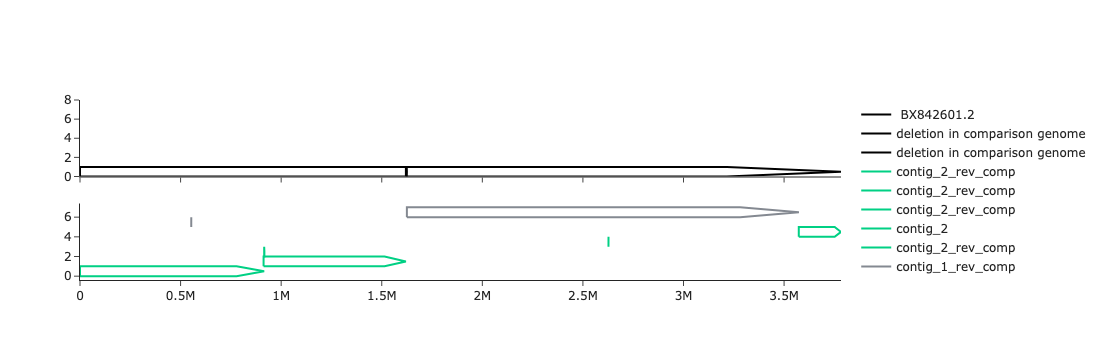

In [117]:
from plotly import graph_objects as go
from plotly.subplots import make_subplots
importlib.reload(du)



df = df1
height=1
def make_global_alignment_map(df, ref_genome_d, height=1):
    """"""
    ## make reference trace
    fig=make_subplots(rows=2, cols=1, shared_xaxes=True)
    if len(ref_genome_d) > 1:
        raise Exception(f"This is currently set up to deal with one contig in reference, i.e. fully assembled, no plasmids")
    base=0
    for name, seq in ref_genome_d.items(): 
        xvals, yvals = make_arrow_from_SE_coords(start=0, end=len(seq), base_ycoord=0, top_ycoord=1, arrow_direction='forward')
        ref_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=df.loc[1,'Tag1'], line={'color':'black'} )#fill="toself"
        fig.add_trace(ref_trace, row=1, col=1)
        
        # mark regions in reference that do not align to comparison genome (deletions in comparision genome)
        ref_len =  len(ref_genome_d[name])
        gaps_in_ref = unaligned_segments(df['S1'], df['E1'], ref_len=ref_len)
        for se_tuple in gaps_in_ref:
            gap_length = se_tuple[1]-se_tuple[0]
            xvals, yvals = make_arrow_from_SE_coords(start=se_tuple[0], end=se_tuple[1], base_ycoord=0, top_ycoord=1, arrow_direction='forward')
            name = f"deletion in comparison genome"
            text = f'Gap length: {gap_length}<br>start: {se_tuple[0]}<br>end: {se_tuple[1]}'
            gap_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=name, line={'color':'black'}, text=text )
            fig.add_trace(gap_trace, row=1, col=1)
    

    color_d = {f'contig_{i}':c for i, c in enumerate(pprefs.colors, start=1)}

    
    base=0
    for ind, row in df.iterrows(): 
        xvals, yvals = make_arrow_from_SE_coords(row['S1'], row['E1'], base_ycoord=base, top_ycoord=height, arrow_direction='forward')
        if not row['same_orientation']:
            name = f"{row['Tag2']}_rev_comp"
        else:
            name = row['Tag2']
        comp_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=name, line={'color':color_d[row['Tag2']]} )#fill="toself"
        fig.add_trace(comp_trace, row=2, col=1)
        height=height+1
        base=base+1
    fig.update_layout(template='simple_white', width=1000)
    fig.update_yaxes(range=[0, height], row=1, col=1)
    return fig



    
fig1 = make_global_alignment_map(df1, ref_genome_d, height=1)
fig1

In [186]:
def map_location_to_genes(start, end, annot_df): 
    """"""   
    feature_starts = list(annot_df['start'])
    feature_ends = list(annot_df['end'])
    start_index = bisect.bisect_left(feature_starts, start)
    end_index   = bisect.bisect_right(feature_ends, end)
    return annot_df.iloc[start_index:end_index]


def make_gap_dfs(ref_genome_gff_fp, df, ref_genome_len): 
    annot_df  = pgf.make_simple_annot_df(ref_genome_gff_fp, start_end=True, contig=True)
    gap_dfs = []
    for gap in ef.unaligned_segments(df['S1'], df['E1'], ref_len=ref_genome_len):
        s,e = gap
        print(df['Tag2'].iloc[0], e-s, s,e)
        del_gene_df = map_location_to_genes(s, e, annot_df)
        if len(del_gene_df)>0:
            gap_dfs.append(del_gene_df)
    return gap_dfs


# mark regions in reference that do not align to comparison genome (deletions in comparision genome)
ref_len =  len(ref_genome_d['BX842601.2'])
comp_genome_1_del_dfs = make_gap_dfs(ref_genome_gff_fp, df1, ref_len)
comp_genome_2_del_dfs = make_gap_dfs(ref_genome_gff_fp, df2, ref_len)

contig_2 1 0 1
contig_2 4924 1620026 1624950
contig_3 1 0 1
contig_3 2008 913571 915579
contig_3 5206 1617244 1622450
contig_3 3 2600557 2600560
contig_3 223 2601339 2601562


In [185]:
comp_genome_2_del_dfs[0]
map_location_to_genes(912571, 916579, annot_df)

,protein_ID,common_name,product,start,end,strand,contig
gene_ID,,,,,,,
gene-Bd0967,cds-CAE78904.1,prc,tail-specific protease,913566,915587,+,BX842601.2
gene-Bd0968,cds-CAE78905.1,Bd0968,hypothetical protein predicted by Glimmer/Critica,915560,915745,-,BX842601.2


In [166]:
len(comp_genome_2_del_dfs)
comp_genome_2_del_dfs[0]

,protein_ID,common_name,product,start,end,strand,contig
gene_ID,,,,,,,
gene-Bd1681,cds-CAE79552.1,Bd1681,putative formyltransferase,1618384,1619271,+,BX842601.2
gene-Bd1683,cds-CAE79553.1,neuB,putative N-acetylneuraminic acid synthetase,1619936,1621006,+,BX842601.2
gene-Bd1684,cds-CAE79554.1,Bd1684,hexapeptide transferase family protein,1621012,1621671,+,BX842601.2


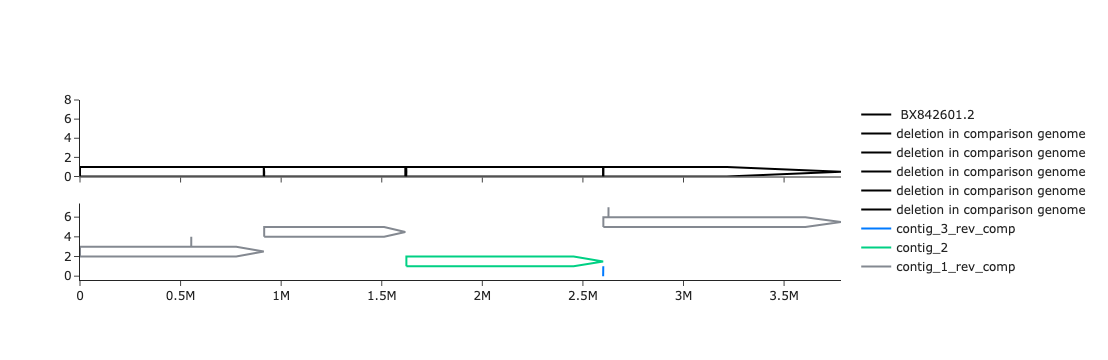

In [118]:
fig2 = make_global_alignment_map(df2, ref_genome_d, height=1)
fig2

In [126]:
ref_genome_d['BX842601.2'][913571:915579]
ref_genome_d['BX842601.2'][1617244:1622450]
ref_genome_d['BX842601.2'][2600557:2600560]

'TCG'